### Demo of using HMMS for sequence classification

    1. Create two Hidden Markov Models
    2. Generate sample sequences from each model.
    3. Split these test sequences into train/test partitions
    4. Train a Classifer containing an HMM for each label
        a. Train 10 models of each label, selecting the model with the lowest LogLikelihood
    
    5. Predict labels using Maximum Likelihood (ignoring class priors)
    6. Predict labels using Maximum A Posteriori
    7. Predict Labels using MLE, but using the original generating HMMS

In [2]:
import sys

In [3]:
sys.path.insert(0, "..")

In [25]:
from hmm import GaussianHMM, HMMSearch, HMMClassifier, plots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.metrics

In [6]:
%matplotlib inline

### Two separate HMM definitions

Different initializations for pi and A, but B is the same

In [7]:
pi_1 = [ .5, .3, .2]
A_1 = [ [0.6, 0.3, 0.1], 
       [0.4, 0.4, 0.2],
       [0.1, 0.3, 0.6]
      ]
means_1 = [-1, 0, 1]
variances_1 = [1, .5, 1]


pi_2 = [ .3, .3, .3]
A_2 = [ [0.1, .3, 0.6], 
       [0.2, 0.5, 0.3],
       [0.2, 0.2, 0.6]
      ]
means_2 = [-2, 0, 2]
variances_2 = [2, 1, 2]

### Generate sample data

In [10]:
hmm1 = GaussianHMM.GaussianHMM(
    init_pi=None,
    init_A=None,
    init_emissions=None,
)
hmm1.pi_ = pi_1
hmm1.A_ = A_1
hmm1.means_ = means_1
hmm1.variances_ = variances_1

In [11]:
print(hmm1.pi_)
print(hmm1.A_)
print(hmm1.means_)
print(hmm1.variances_)

[0.5, 0.3, 0.2]
[[0.6, 0.3, 0.1], [0.4, 0.4, 0.2], [0.1, 0.3, 0.6]]
[-1, 0, 1]
[1, 0.5, 1]


In [12]:
hmm2 = GaussianHMM.GaussianHMM(
    
    init_pi=None,
    init_A=None,
    init_emissions=None,
    implementation="python",
)
hmm2.pi_ = pi_2
hmm2.A_ = A_2
hmm2.means_ = means_2
hmm2.variances_ = variances_2

In [13]:
print(hmm2.pi_)
print(hmm2.A_)
print(hmm2.means_)
print(hmm2.variances_)

[0.3, 0.3, 0.3]
[[0.1, 0.3, 0.6], [0.2, 0.5, 0.3], [0.2, 0.2, 0.6]]
[-2, 0, 2]
[2, 1, 2]


### Train on an imbalanced dataset

In [14]:
a_observations, a_hiddens = hmm1.sample(n_samples=10000, length=10)
b_observations, b_hiddens = hmm2.sample(n_samples=5000, length=10)

Verifying that matrices were normalied

In [15]:
a_train_observations, a_test_observations = sklearn.model_selection.train_test_split(a_observations)
b_train_observations, b_test_observations = sklearn.model_selection.train_test_split(b_observations)

X_train = np.concatenate([a_train_observations, b_train_observations])
y_train = np.asarray(["class-a"] * len(a_train_observations) + ["class-b"] * len(b_train_observations))
X_test = np.concatenate([a_test_observations, b_test_observations])
y_test = np.asarray(["class-a"] * len(a_test_observations) + ["class-b"] * len(b_test_observations))


In [16]:
pd.Series(y_train).value_counts()

class-a    7500
class-b    3750
dtype: int64

### Train the classifier 
I don't quite have it working to select an optimal number of states. In the literature AIC, BIC, Cross Validation are all mentioned as options, with conflicting advice.  The marketing literature also measures how well the hidden states are separated from each other, and there is interesting work done in the biological world, especially with regards to animal tracking.  Also can look at the how things are done in the Protien/dna sequencing field

 * https://core.ac.uk/download/pdf/82597511.pdf (Analysis of Genome Data)
 * https://arxiv.org/abs/1701.08673 (HMM Selection with Animal tracking applications)
 * http://etd.fcla.edu/UF/UFE0041157/zhang_x.pdf (Doctoral Thesis - yikes)
 * http://www.columbia.edu/~on2110/Papers/Ebbes_Netzer_2018.pdf (arketing science)

Instead, we'll fix the number of states, and train 10 models for each state, keeping the model that best approximates the generated data.

In [18]:
a_new = GaussianHMM.GaussianHMM(
    n_components=3,
    n_iterations=50,
    n_inits=4
)

b_new = GaussianHMM.GaussianHMM(
    n_components=3,
    n_iterations=50,
    n_inits=4
)

# Classifier with models learned from the data
classifier_mle = HMMClassifier.HMMClassifier(
    {
        "class-a": a_new,
        "class-b": b_new,
        
    },
    predict_method="mle",
)

classifier_map = HMMClassifier.HMMClassifier(
    {
        "class-a": a_new,
        "class-b": b_new,
        
    },
    predict_method="map",
)

# Classifer using the models that generated the data
original = HMMClassifier.HMMClassifier(
    {
        "class-a": hmm1,
        "class-b": hmm2,
    },
    predict_method="mle"
)

In [19]:
%time classifier_mle.fit(X_train, y_train)

/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


CPU times: user 24.8 ms, sys: 28.8 ms, total: 53.6 ms
Wall time: 7.85 s


HMMClassifier(default_estimator=CategoricalHMM(allowed_to_use_log=True, implementation='scaling',
        init_A='random', init_emissions='random', init_pi='random',
        n_components=1, n_features=None, n_inits=1, n_iterations=100,
        n_jobs=-1, random_state=None, smoothing=None, tol=1e-06, verbose=0),
       estimators={'class-a': GaussianHMM(allowed_to_use_log=True, implementation='scaling',
      init_A='random', init_emissions='kmeans', init_pi='random',
      n_components=3, n_inits=4, n_iterations=50, n_jobs=-1,
      random_state=None, tol=1e-06, variance_regularization=1e-06,
      verbose=0), 'c...=50, n_jobs=-1,
      random_state=None, tol=1e-06, variance_regularization=1e-06,
      verbose=0)},
       predict_method='mle')

In [20]:
%time classifier_map.fit(X_train, y_train)

/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


CPU times: user 21 ms, sys: 3.75 ms, total: 24.8 ms
Wall time: 5.18 s


HMMClassifier(default_estimator=CategoricalHMM(allowed_to_use_log=True, implementation='scaling',
        init_A='random', init_emissions='random', init_pi='random',
        n_components=1, n_features=None, n_inits=1, n_iterations=100,
        n_jobs=-1, random_state=None, smoothing=None, tol=1e-06, verbose=0),
       estimators={'class-a': GaussianHMM(allowed_to_use_log=True, implementation='scaling',
      init_A='random', init_emissions='kmeans', init_pi='random',
      n_components=3, n_inits=4, n_iterations=50, n_jobs=-1,
      random_state=None, tol=1e-06, variance_regularization=1e-06,
      verbose=0), 'c...=50, n_jobs=-1,
      random_state=None, tol=1e-06, variance_regularization=1e-06,
      verbose=0)},
       predict_method='map')

### Internal States of learned models

In [22]:
print("pi")
print(classifier_mle.trained_models_["class-a"].pi_)
print("A")
print(classifier_mle.trained_models_["class-a"].A_)
print("means")
print(classifier_mle.trained_models_["class-a"].means_)
print("variances")
print(classifier_mle.trained_models_["class-a"].variances_)


pi
[0.38287277 0.19220553 0.42492169]
A
[[0.46348556 0.10479069 0.43172375]
 [0.07227585 0.59045533 0.33726882]
 [0.33599604 0.17728714 0.48671682]]
means
[-1.24978415  1.03592288 -0.05908414]
variances
[0.86032516 0.95588552 0.54056917]


In [23]:
print("pi")
print(classifier_mle.trained_models_["class-b"].pi_)
print("A")
print(classifier_mle.trained_models_["class-b"].A_)
print("means")
print(classifier_mle.trained_models_["class-b"].means_)
print("variances")
print(classifier_mle.trained_models_["class-b"].variances_)


pi
[0.36675785 0.26186642 0.37137573]
A
[[0.08993588 0.51188881 0.39817531]
 [0.19941443 0.53137703 0.26920854]
 [0.22914946 0.2567376  0.51411294]]
means
[-1.89830083  2.2612938   0.15387867]
variances
[2.15810707 1.71824977 1.1566754 ]


### MLE Models


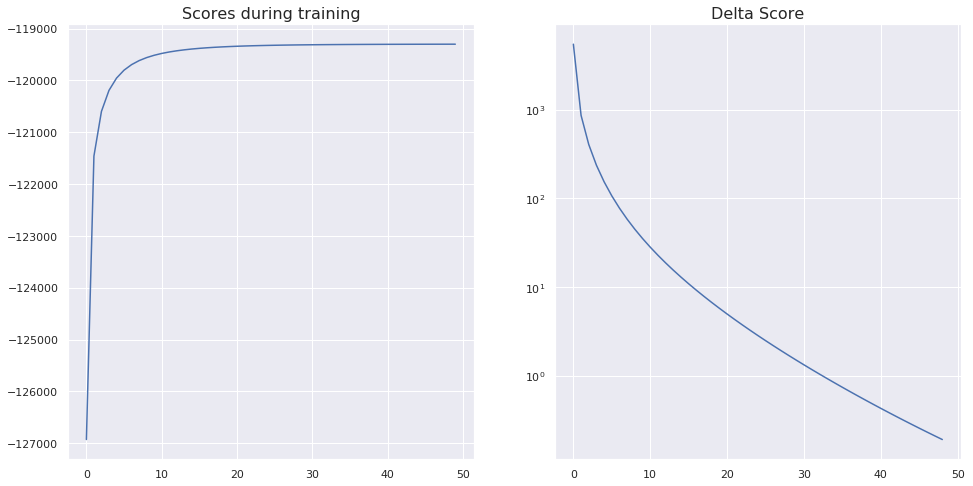

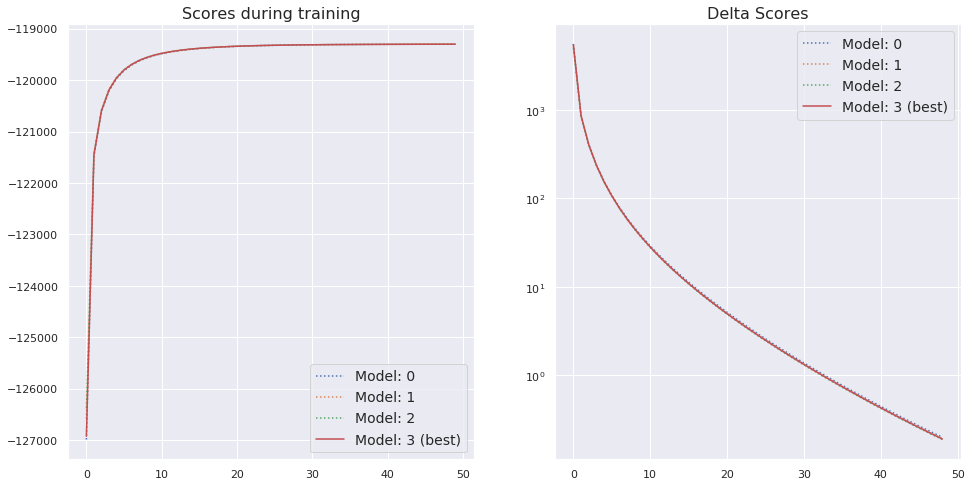

In [28]:
_ = plots.learning_plot(classifier_mle.trained_models_["class-a"].loglikelihoods_)
_ = plots.multiple_learning_plot(classifier_mle.trained_models_["class-a"].explored_loglikelihoods_)

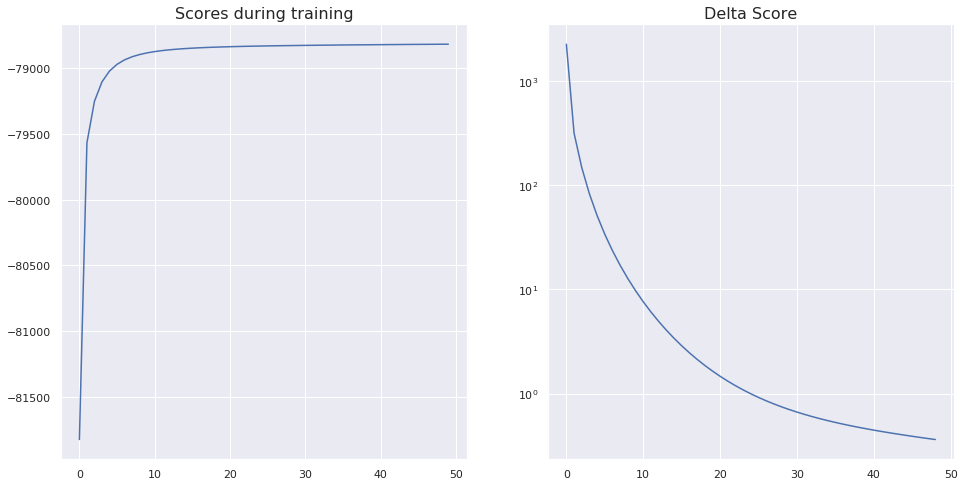

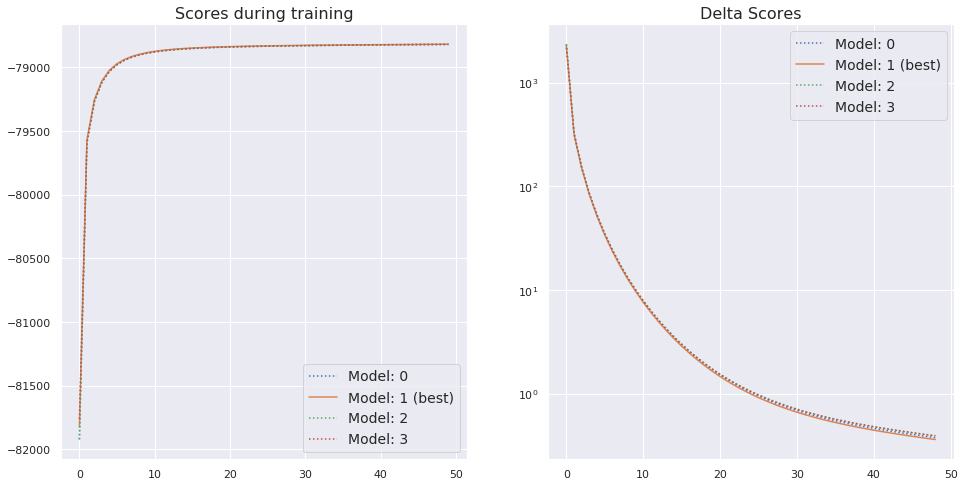

In [29]:
_ = plots.learning_plot(classifier_mle.trained_models_["class-b"].loglikelihoods_)
_ = plots.multiple_learning_plot(classifier_mle.trained_models_["class-b"].explored_loglikelihoods_)

### MAP Models

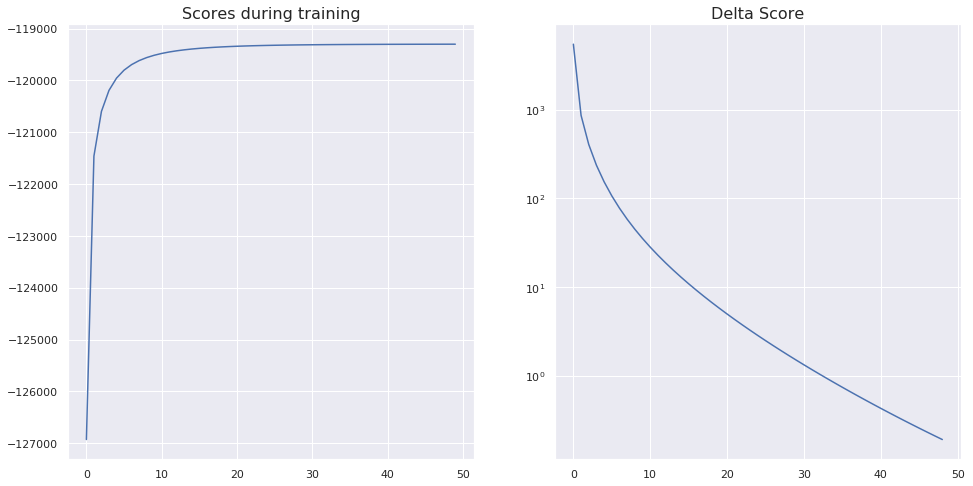

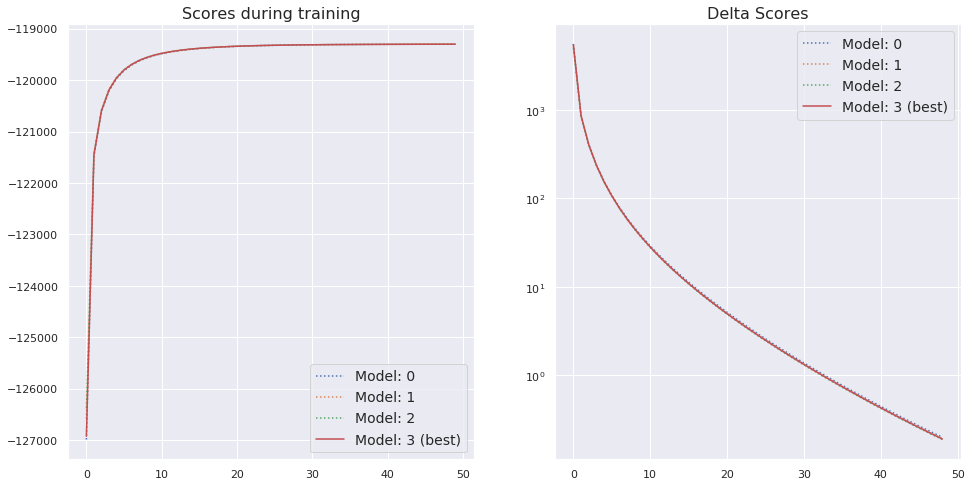

In [30]:
_ = plots.learning_plot(classifier_map.trained_models_["class-a"].loglikelihoods_)
_ = plots.multiple_learning_plot(classifier_map.trained_models_["class-a"].explored_loglikelihoods_)

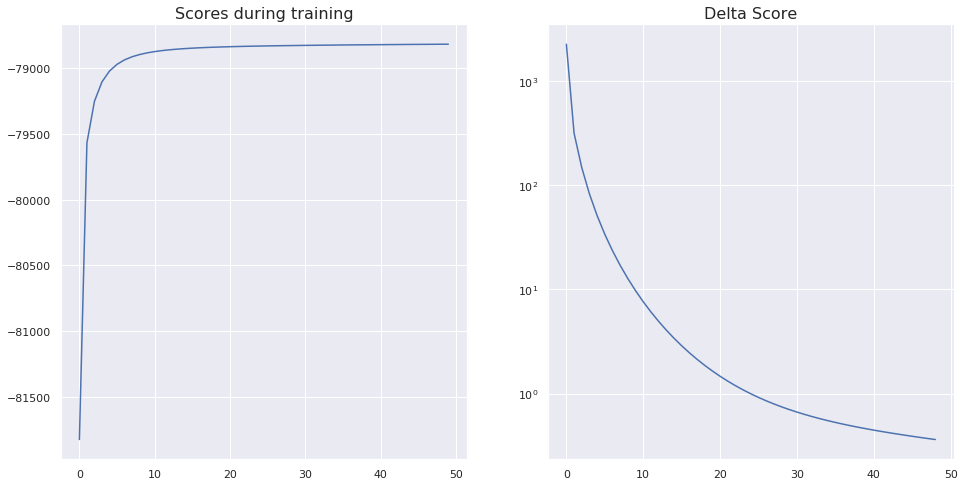

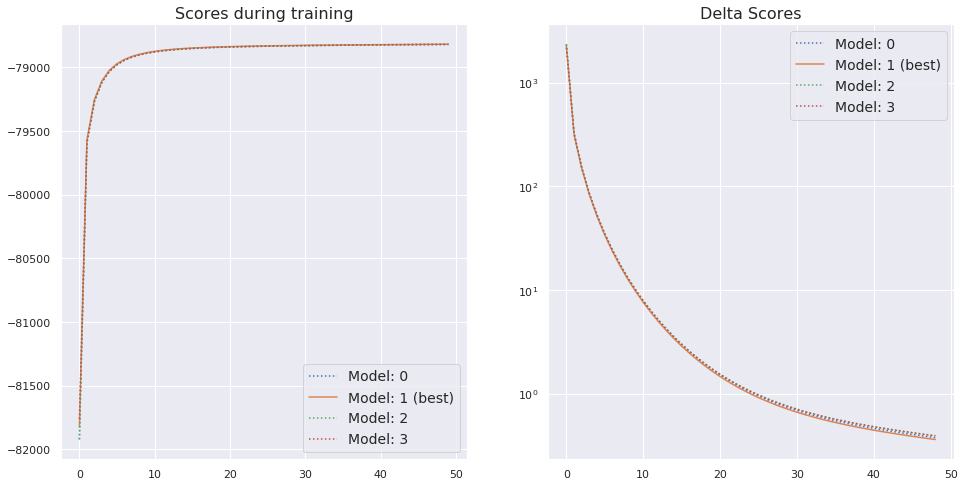

In [31]:
_ = plots.learning_plot(classifier_map.trained_models_["class-b"].loglikelihoods_)
_ = plots.multiple_learning_plot(classifier_map.trained_models_["class-b"].explored_loglikelihoods_)

Models above are identical in resulting LLs, but this is because they all grab the random state and go to a 
thread, so they all end up with identical initializations

##### Build the model based on the original distributions
Not really "fitting" the model, as we intialized it with zero iterations.

In [32]:
%time original.fit(X_train, y_train)

/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)


CPU times: user 2.86 s, sys: 0 ns, total: 2.86 s
Wall time: 2.85 s


../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)


HMMClassifier(default_estimator=CategoricalHMM(allowed_to_use_log=True, implementation='scaling',
        init_A='random', init_emissions='random', init_pi='random',
        n_components=1, n_features=None, n_inits=1, n_iterations=100,
        n_jobs=-1, random_state=None, smoothing=None, tol=1e-06, verbose=0),
       estimators={'class-a': GaussianHMM(allowed_to_use_log=True, implementation='scaling', init_A=None,
      init_emissions=None, init_pi=None, n_components=3, n_inits=1,
      n_iterations=100, n_jobs=-1, random_state=None, tol=1e-06,
      variance_regularization=1e-06, verbose=0), 'class-b': Gaussian...tions=100, n_jobs=-1, random_state=None, tol=1e-06,
      variance_regularization=1e-06, verbose=0)},
       predict_method='mle')

In [33]:
y_test_proba_mle = classifier_mle.predict_proba(X_test)
y_test_proba_map = classifier_map.predict_proba(X_test)
y_origin_test_proba_mle = original.predict_proba(X_test)

### Examine Predictions


In [34]:
pd.DataFrame(y_test_proba_mle, columns=["class-a", "class-b"])

class-a   class-b
0     9.315997e-01  0.068400
1     8.809959e-01  0.119004
2     8.887099e-01  0.111290
3     9.168876e-01  0.083112
4     9.669582e-01  0.033042
5     8.103085e-01  0.189691
6     8.627592e-01  0.137241
7     4.710320e-01  0.528968
8     9.546674e-01  0.045333
9     8.551656e-01  0.144834
10    5.764156e-01  0.423584
11    9.105782e-01  0.089422
12    7.341328e-01  0.265867
13    9.686965e-01  0.031304
14    9.761571e-01  0.023843
15    9.744857e-01  0.025514
16    9.879727e-01  0.012027
17    9.480678e-01  0.051932
18    9.410656e-01  0.058934
19    9.323522e-01  0.067648
20    8.568110e-01  0.143189
21    9.740064e-01  0.025994
22    9.864697e-01  0.013530
23    9.264876e-01  0.073512
24    9.001102e-01  0.099890
25    9.906902e-01  0.009310
26    9.925643e-01  0.007436
27    9.267348e-01  0.073265
28    5.969780e-01  0.403022
29    5.920268e-01  0.407973
...            ...       ...
3720  2.164370e-01  0.783563
3721  6.008551e-08  1.000000
3722  3.706269e-04  0.999629
3723  7.126916e-03  0.992873
3724  2.478715e-02  0.975213
3725  7.698674e-01  0.230133
3726  5.689905e-04  0.999431
3727  4.001375e-01  0.599863
3728  8.743012e-01  0.125699
3729  5.806514e-01  0.419349
3730  6.802924e-05  0.999932
3731  6.455110e-03  0.993545
3732  1.158206e-01  0.884179
3733  6.092009e-01  0.390799
3734  9.559913e-01  0.044009
3735  4.618894e-03  0.995381
3736  1.786795e-04  0.999821
3737  2.088707e-07  1.000000
3738  4.190016e-05  0.999958
3739  3.328226e-02  0.966718
3740  4.882295e-02  0.951177
3741  8.861172e-03  0.991139
3742  2.633888e-04  0.999737
3743  3.129031e-06  0.999997
3744  7.772031e-03  0.992228
3745  3.159028e-03  0.996841
3746  1.745178e-03  0.998255
3747  2.988575e-03  0.997011
3748  5.392916e-05  0.999946
3749  5.081774e-02  0.949182

[3750 rows x 2 columns]

In [35]:
pd.DataFrame(y_test_proba_map, columns=["class-a", "class-b"])

class-a   class-b
0     9.645888e-01  0.035411
1     9.367335e-01  0.063267
2     9.410761e-01  0.058924
3     9.566420e-01  0.043358
4     9.832016e-01  0.016798
5     8.952159e-01  0.104784
6     9.263239e-01  0.073676
7     6.404103e-01  0.359590
8     9.768080e-01  0.023192
9     9.219291e-01  0.078071
10    7.312990e-01  0.268701
11    9.531965e-01  0.046804
12    8.466858e-01  0.153314
13    9.840994e-01  0.015901
14    9.879347e-01  0.012065
15    9.870780e-01  0.012922
16    9.939500e-01  0.006050
17    9.733417e-01  0.026658
18    9.696381e-01  0.030362
19    9.649920e-01  0.035008
20    9.228845e-01  0.077116
21    9.868321e-01  0.013168
22    9.931888e-01  0.006811
23    9.618412e-01  0.038159
24    9.474295e-01  0.052571
25    9.953233e-01  0.004677
26    9.962683e-01  0.003732
27    9.619744e-01  0.038026
28    7.476346e-01  0.252365
29    7.437397e-01  0.256260
...            ...       ...
3720  3.558540e-01  0.644146
3721  1.201710e-07  1.000000
3722  7.409792e-04  0.999259
3723  1.415297e-02  0.985847
3724  4.837521e-02  0.951625
3725  8.699718e-01  0.130028
3726  1.137334e-03  0.998863
3727  5.715688e-01  0.428431
3728  9.329357e-01  0.067064
3729  7.346989e-01  0.265301
3730  1.360492e-04  0.999864
3731  1.282742e-02  0.987173
3732  2.075972e-01  0.792403
3733  7.571471e-01  0.242853
3734  9.775005e-01  0.022499
3735  9.195315e-03  0.990805
3736  3.572952e-04  0.999643
3737  4.177414e-07  1.000000
3738  8.379681e-05  0.999916
3739  6.442047e-02  0.935580
3740  9.310045e-02  0.906900
3741  1.756668e-02  0.982433
3742  5.266388e-04  0.999473
3743  6.258043e-06  0.999994
3744  1.542419e-02  0.984576
3745  6.298159e-03  0.993702
3746  3.484276e-03  0.996516
3747  5.959340e-03  0.994041
3748  1.078525e-04  0.999892
3749  9.672037e-02  0.903280

[3750 rows x 2 columns]

In [36]:
pd.Series(np.exp(classifier_map.class_log_prior_), ["class-a", "class-b"])

class-a    0.666667
class-b    0.333333
dtype: float64

### ROC
All models do well as the generating process is well separated

In [38]:
print("Original HMM AUC")
print(sklearn.metrics.roc_auc_score(y_test, y_origin_test_proba_mle[:, 1]))
print("Learned HMM AUC: MLE")
print(sklearn.metrics.roc_auc_score(y_test, y_test_proba_mle[:, 1]))
print("Learned HMM AUC: MAP")
print(sklearn.metrics.roc_auc_score(y_test, y_test_proba_map[:, 1]))

Original HMM AUC
0.9666009599999998
Learned HMM AUC: MLE
0.96648512
Learned HMM AUC: MAP
0.96648512


Text(0.5,1,'ROC - Classification example')

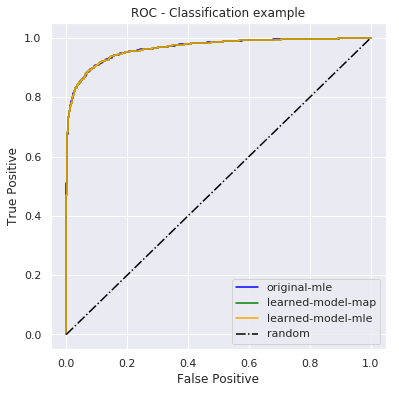

In [39]:
f, ax = plt.subplots(figsize=(6,6))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test == "class-b", y_origin_test_proba_mle[:, 1])
ax.plot(fpr, tpr, label="original-mle", color="blue")
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test == "class-b", y_test_proba_map[:, 1])
ax.plot(fpr, tpr, label="learned-model-map", color="green")
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test == "class-b", y_test_proba_mle[:, 1])
ax.plot(fpr, tpr, label="learned-model-mle", color="orange")
ax.plot(np.arange(0, 1.01, .1),np.arange(0, 1.01, .1), label="random", color="black", linestyle="-.")
ax.legend()
ax.set_ylabel("True Positive")
ax.set_xlabel("False Positive")
ax.set_title("ROC - Classification example")


In [40]:
predicted_y_mle = classifier_mle.predict(X_test)
predicted_y_map = classifier_map.predict(X_test)
predicted_y_orig_mle = original.predict(X_test)

### Standard Classification Metrics

The MLE and MAP models trade off precision and recall between classes.

In [41]:
print(sklearn.metrics.classification_report(y_test, predicted_y_mle))

              precision    recall  f1-score   support

     class-a       0.94      0.93      0.94      2500
     class-b       0.86      0.89      0.87      1250

   micro avg       0.91      0.91      0.91      3750
   macro avg       0.90      0.91      0.90      3750
weighted avg       0.92      0.91      0.91      3750



In [42]:
print(sklearn.metrics.classification_report(y_test, predicted_y_map))

              precision    recall  f1-score   support

     class-a       0.92      0.96      0.94      2500
     class-b       0.91      0.84      0.88      1250

   micro avg       0.92      0.92      0.92      3750
   macro avg       0.92      0.90      0.91      3750
weighted avg       0.92      0.92      0.92      3750



In [43]:
print(sklearn.metrics.classification_report(y_test, predicted_y_orig_mle))

              precision    recall  f1-score   support

     class-a       0.94      0.93      0.93      2500
     class-b       0.86      0.89      0.87      1250

   micro avg       0.91      0.91      0.91      3750
   macro avg       0.90      0.91      0.90      3750
weighted avg       0.91      0.91      0.91      3750

